In [1]:
import torch
import torchvision
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, ToTensor, Normalize

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)

In [2]:
transforms = Compose(
    [RandomHorizontalFlip(),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    Resize((256, 256))])

batch_size = 4

trainset = torchvision.datasets.ImageFolder(root='./data/sorted/train', transform=transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

validationset = torchvision.datasets.ImageFolder(root='./data/sorted/validation', transform=transforms)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size,
                                          shuffle=True)

testset = torchvision.datasets.ImageFolder(root='./data/sorted/test', transform=transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

classes = ("battery", "biological", "brown-glass", "cardboard", "clothes", "green-glass", "metal", "paper", "plastic", "shoes", "trash", "white-glass")

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(59536, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, len(classes))

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = Net()

net = models.resnet50(pretrained=True)
for param in net.parameters():
    param.requires_grad = False

    
net.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Dropout(0.2),
               nn.Linear(128, 12))
net = net.to(device)


In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum = 0.9)

In [5]:
hist_train = []
hist_validation = []
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    net.train()

    # training
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()

    print('epoch %d:' % (epoch + 1))
    print('loss: %.3f' % (running_loss / len(trainloader)))
    hist_train.append(running_loss / len(trainloader))
    running_loss = 0.0

    net.eval()

    # validation
    for i, data in enumerate(validationloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # print statistics
        running_loss += loss.item()

    print('validation loss: %.3f' % (running_loss / len(validationloader)))

    hist_validation.append(running_loss / len(validationloader))

print('Finished Training')

epoch 1:
loss: 1.002
validation loss: 0.354
epoch 2:
loss: 0.661
validation loss: 0.272
epoch 3:
loss: 0.600
validation loss: 0.256
epoch 4:
loss: 0.551
validation loss: 0.249
epoch 5:
loss: 0.512
validation loss: 0.248
epoch 6:
loss: 0.512
validation loss: 0.258
epoch 7:
loss: 0.497
validation loss: 0.232
epoch 8:
loss: 0.490
validation loss: 0.228
epoch 9:
loss: 0.475
validation loss: 0.229
epoch 10:
loss: 0.442
validation loss: 0.225
epoch 11:
loss: 0.470
validation loss: 0.200
epoch 12:
loss: 0.428
validation loss: 0.242
epoch 13:
loss: 0.434
validation loss: 0.205
epoch 14:
loss: 0.427
validation loss: 0.218
epoch 15:
loss: 0.403
validation loss: 0.217
epoch 16:
loss: 0.401
validation loss: 0.223
epoch 17:
loss: 0.410
validation loss: 0.212
epoch 18:
loss: 0.388
validation loss: 0.211
epoch 19:
loss: 0.380
validation loss: 0.204
epoch 20:
loss: 0.383
validation loss: 0.195
epoch 21:
loss: 0.386
validation loss: 0.239
epoch 22:
loss: 0.376
validation loss: 0.176
epoch 23:
loss: 0.3

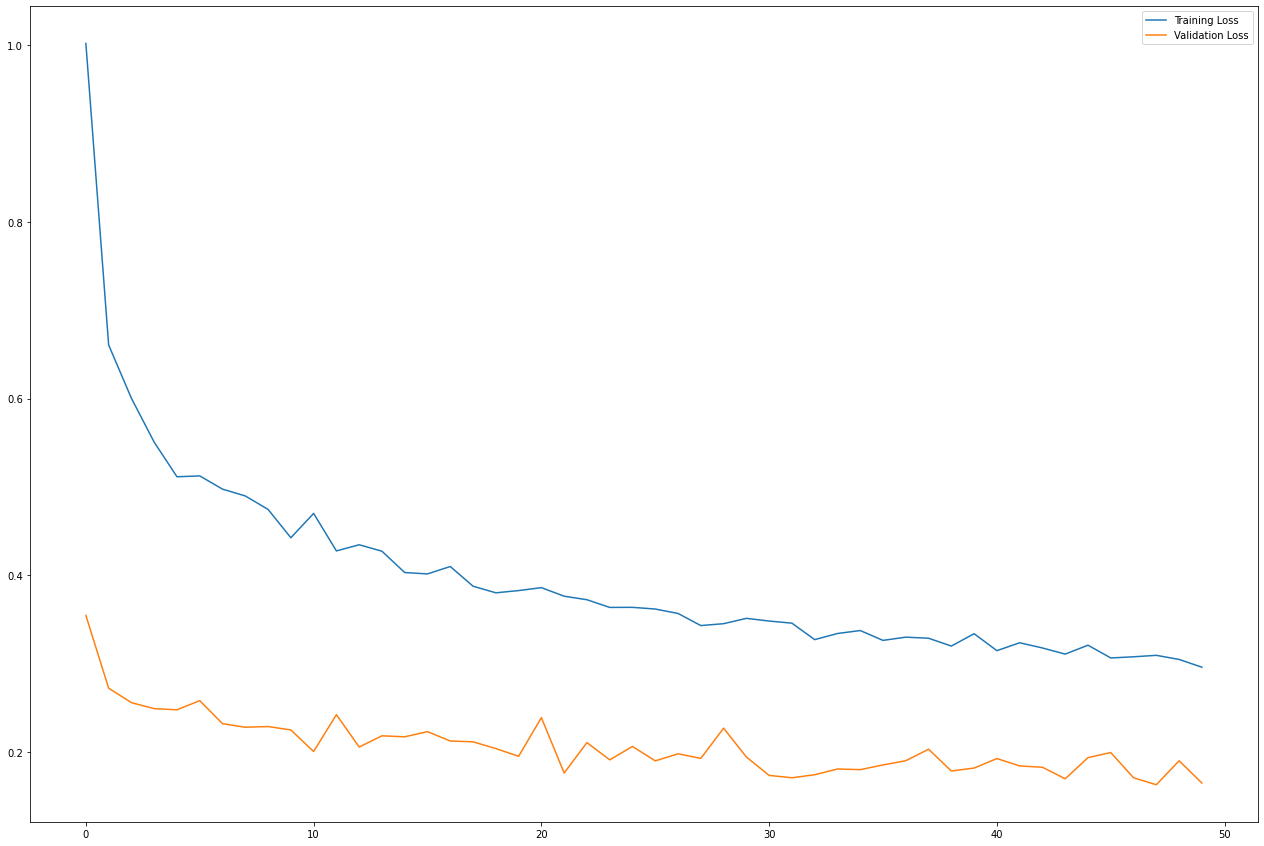

In [6]:
import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

plt.plot(hist_train, label='training loss')
plt.plot(hist_validation, label='validation loss')

plt.legend(['Training Loss', 'Validation Loss'])

plt.show()

In [7]:
PATH = './models/model.hdf5'
torch.save(net, PATH)

In [8]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

total_correct = 0
total_total = 0

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    total_correct += float(correct_count)
    total_total += total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

print("Total Accuracy is: {:.1f} %".format(100 * total_correct / total_total))

Accuracy for class battery is: 90.5 %
Accuracy for class biological is: 97.0 %
Accuracy for class brown-glass is: 98.4 %
Accuracy for class cardboard is: 93.3 %
Accuracy for class clothes is: 97.6 %
Accuracy for class green-glass is: 92.1 %
Accuracy for class metal is: 89.6 %
Accuracy for class paper is: 95.2 %
Accuracy for class plastic is: 83.9 %
Accuracy for class shoes is: 98.0 %
Accuracy for class trash is: 97.1 %
Accuracy for class white-glass is: 89.7 %
Total Accuracy is: 95.0 %
